In [1]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import h5py

from sklearn.feature_extraction import image

%matplotlib inline

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def make_binary_image(im):
    im_bin=im.copy()
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i,j]>127: 
                im_bin[i,j]=1
            else:
                im_bin[i,j]=0
    
    return im_bin
                
def add_noise(img, delta):
    
    flatten_img = img.reshape((img.shape[0]*img.shape[1],)).copy()
    img_len = flatten_img.shape[0]
    
    for idx in range(img_len):
        rand_value = random.random()
        if flatten_img[idx] == 0:
            if rand_value < delta:
                flatten_img[idx] = 1
        else:
            if rand_value < delta:
                flatten_img[idx] = 0
                
    noisy_img = flatten_img.reshape(img.shape[0],img.shape[1])
                
    return noisy_img
            

path_dir_BSD = './source_data/training_data/'
file_list_BSD = os.listdir(path_dir_BSD)
file_list_BSD.sort()

In [2]:
len_tr_dataset = 50
binary_bsd_dataset = np.zeros(((len_tr_dataset,321,481)))

In [3]:
for idx in range(len_tr_dataset):
    
    img = mpimg.imread(path_dir_BSD + file_list_BSD[idx])
    gray_img = rgb2gray(img)
    
    if gray_img.shape[0] == 481:
        gray_img = np.rot90(gray_img)
        
    binary_img = make_binary_image(gray_img)
    
    binary_bsd_dataset[idx,:,:] = binary_img
    

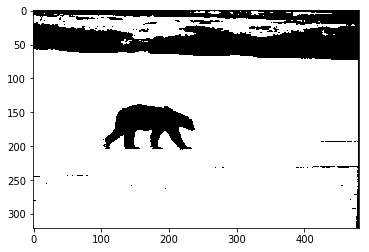

In [4]:
## plot true img
plt.imshow(binary_bsd_dataset[0], cmap = plt.get_cmap('gray'))

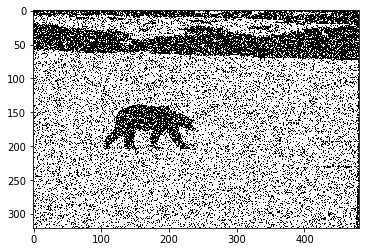

In [5]:
## plot noisy img
plt.imshow(add_noise(binary_bsd_dataset[0], 0.2), cmap = plt.get_cmap('gray'))

In [6]:
from keras.utils import np_utils
def get_onehot_context(context, nb_classes):
    onehot_context = np_utils.to_categorical(context,nb_classes)
    flatten_onehot_context = onehot_context.reshape(onehot_context.shape[0],onehot_context.shape[1]*onehot_context.shape[2])
    return flatten_onehot_context

Using TensorFlow backend.


In [ ]:
k_arr = [3,5,7,9,11,13,15,17,19,21]
delta_arr = [0.05, 0.1, 0.2, 0.25]

nb_classes = 2


x_size = 321
y_size = 481

for delta_ in (delta_arr):
    for k in (k_arr):
        
        print ('delta : ' + str(delta_)+ ' k : '+ str(k))
        
        context_size = (k*k)*nb_classes

        X_data = np.zeros((len_tr_dataset*x_size*y_size,context_size))
        Y_data = np.zeros((len_tr_dataset*x_size*y_size,3))

        for img_idx in range(len_tr_dataset):

            ## generate X_data
#             context_data = np.zeros((x_size*y_size,(k*k)))

            img = binary_bsd_dataset[img_idx].copy()
            noisy_img = add_noise(img, delta_)

            padding_binary_bsd_data = np.pad(noisy_img,(k//2,k//2),'constant',constant_values=(0, 0))

            patches = image.extract_patches_2d(padding_binary_bsd_data, (k,k))
            flatten_patches = patches.reshape((patches.shape[0],patches.shape[1]*patches.shape[2]))

#             context_data[:,0:(k*k-1)//2] =  flatten_patches[:,0:(k*k-1)//2]
#             context_data[:,(k*k-1)//2:] =  flatten_patches[:,(k*k-1)//2+1:]
            
            flatten_onehot_context = get_onehot_context(flatten_patches, nb_classes)

            X_data[img_idx*(x_size*y_size):(img_idx+1)*(x_size*y_size),:] = flatten_onehot_context[:]

            ## generate Y_data
            label_data = np.zeros((x_size*y_size,1))

            flatten_img = img.flatten()
#             flatten_noisy_img = noisy_img.flatten()

            Y_data[img_idx*(x_size*y_size):(img_idx+1)*(x_size*y_size),:] = flatten_img[:]
            
        f = h5py.File("Supervised_2D_training_data_k"+(str(k))+"_delta"+(str(int(delta_*100)))+".hdf5", "w")
        f.create_dataset('X_data', data=X_data)
        f.create_dataset('Y_data', data=Y_data)
        f.close()
        
        
        